  # Autoencoder - Baseline mode - Copy 1

# Setup

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
%load_ext autoreload  
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os
import sys
import csv
import glob
import json
import time
import types
import copy
import pprint
import logging 
from datetime import datetime
for p in ['./src','../..']:
    if p not in sys.path:
        print(f"insert {p}")
        sys.path.insert(0, p)
print(sys.path)
import shutil
import getpass
import yaml

from matplotlib import pyplot as plt
from typing import Dict, List, Tuple
import scipy
from scipy.sparse import csr_matrix
from tqdm import tqdm

import numpy as np

import pandas as pd

import torch
import torch.nn.functional as F
from torchinfo import summary

torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=150, profile=None, sci_mode=None)
print(torch.__version__)

pp = pprint.PrettyPrinter(indent=4)
pd.options.display.width = 132
torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=150, profile=None, sci_mode=None)
np.set_printoptions(edgeitems=3, infstr='inf', linewidth=150, nanstr='nan')

os.environ["WANDB_NOTEBOOK_NAME"] = "Autoencoder_dev.ipynb"
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import wandb

insert ./src
insert ../..
['../..', './src', '/home/kevin/miniforge3/envs/ptsnnl/lib/python311.zip', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/lib-dynload', '', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/site-packages', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/site-packages/cytominer_eval-0.1-py3.11.egg']
2.2.2


In [3]:
from KevinsRoutines.utils.utils_wandb import init_wandb, wandb_log_metrics,wandb_watch
from KevinsRoutines.utils.utils_general import list_namespace
import snnl.utils as utils 

from snnl.utils import parse_args, load_configuration, set_global_seed, get_device, set_device
from snnl.utils import define_autoencoder_model, init_resume_training
from snnl.utils import save_checkpoint_v5, load_checkpoint_v5
from snnl.utils import plot_model_parms, plot_train_history, plot_classification_metrics, plot_regression_metrics
from snnl.utils import display_model_summary, display_model_hyperparameters, display_model_gradients, display_model_parameters
from snnl.utils import display_epoch_metrics, display_cellpainting_batch, display_model_state_dict

In [4]:
timestamp = datetime.now().strftime('%Y_%m_%d_%H:%M:%S')
# print('Timestamp: ',timestamp)
logger = logging.getLogger(__name__) 
logLevel = os.environ.get('LOG_LEVEL', 'INFO').upper()
FORMAT = '%(asctime)s - %(name)s - %(levelname)s: - %(message)s'
logging.basicConfig(level="INFO", format= FORMAT)

logger.info(f" Excution started : {timestamp} ")
logger.info(f" Pytorch version  : {torch.__version__}  \t\t Number of threads: {torch.get_num_threads()}")
logger.info(f" Scipy version    : {scipy.__version__}  \t\t Numpy version : {np.__version__}")
logger.info(f" WandB version    : {wandb.__version__}  \t\t Pandas version: {pd.__version__}  ")
# logger.info(f" Search path      : {sys.path}")

2024-09-05 18:02:09,441 - __main__ - INFO: -  Excution started : 2024_09_05_18:02:09 
2024-09-05 18:02:09,442 - __main__ - INFO: -  Pytorch version  : 2.2.2  		 Number of threads: 7
2024-09-05 18:02:09,443 - __main__ - INFO: -  Scipy version    : 1.12.0  		 Numpy version : 1.26.4
2024-09-05 18:02:09,445 - __main__ - INFO: -  WandB version    : 0.17.4  		 Pandas version: 2.2.1  


## main(args)

In [5]:
# RUNMODE = 'baseline'
RUNMODE = 'snnl'
GPU_ID = 1
LATENT_DIM    = 150
HIDDEN_1      = 512
EPOCHS        = 1
COMPOUNDS_PER_BATCH = 200
# TEMP          = 1.00
# TEMP_LR       = 0.00   ##1.0e-05
# ADAM_WEIGHT_DECAY = 0.001
# SNNL_FACTOR   = 3.0
# TEMP          = 1.00
# TEMP_LR       = 0.00   ##1.0e-05
# ADAM_WEIGHT_DECAY = 0.1
# LOSS_FACTOR   = 134.0
# SNNL_FACTOR   = 3.0

In [6]:
# if __name__ == "__main__":
cli_args = f" --runmode            {RUNMODE}" \
            f" --configuration      hyperparameters/ae_baseline_{LATENT_DIM:03d}_{HIDDEN_1}_cpb.yaml" \
            f" --gpu_id             {GPU_ID} " \
            f" --epochs             {EPOCHS} " \
            f" --cpb                {COMPOUNDS_PER_BATCH}"\
            f" --seed               4321"\
            f" --gpu_id             {GPU_ID} "  \
            f" "
# f" --snnl_factor        {SNNL_FACTOR}"\
# f" --configuration      hyperparameters/ae_snglOpt_{LATENT_DIM:03d}_{HIDDEN_1}_cpb.yaml" \
# f" --ckpt               AE_baseline_20240614_snglOpt-{LATENT_DIM}Ltnt{HIDDEN_1}{HIDDEN_2}_ep_300.pt "
# f" --wandb              "\

cli_args = parse_args(cli_args.split())
cli_args

args = load_configuration(cli_args)
# args.ckpt

Namespace(configuration='hyperparameters/ae_baseline_150_512_cpb.yaml', ckpt=None, cpb=200, exp_title=None, epochs=1, gpu_id=1, learning_rate=None, exp_id=None, runmode='snnl', random_seed=4321, use_prim_optimizer=True, use_temp_optimizer=False, use_annealing=False, anneal_patience=15, use_single_loss=False, temperature=None, adam_weight_decay=None, loss_factor=None, snnl_factor=None, temperatureLR=None, WANDB_ACTIVE=False)

2024-09-05 18:02:18,500 - snnl.utils.utils_ptsnnl - INFO: -  command line param configuration             : [hyperparameters/ae_baseline_150_512_cpb.yaml]
2024-09-05 18:02:18,500 - snnl.utils.utils_ptsnnl - INFO: -  command line param ckpt                      : [None]
2024-09-05 18:02:18,501 - snnl.utils.utils_ptsnnl - INFO: -  command line param cpb                       : [200]
2024-09-05 18:02:18,502 - snnl.utils.utils_ptsnnl - INFO: -  command line param exp_title                 : [None]
2024-09-05 18:02:18,503 - snnl.utils.utils_ptsnnl - INFO: -  command line param epochs                    : [1]
2024-09-05 18:02:18,503 - snnl.utils.utils_ptsnnl - INFO: -  command line param gpu_id                    : [1]
2024-09-05 18:02:18,504 - snnl.utils.utils_ptsnnl - INFO: -  command line param learning_rate             : [None]
2024-09-05 18:02:18,504 - snnl.utils.utils_ptsnnl - INFO: -  command line param exp_id                    : [None]
2024-09-05 18:02:18,505 - snnl.utils.utils_ptsn

In [7]:
### Set random seed and gpu device
set_global_seed(args.random_seed)

if args.ckpt is not None:
    if os.path.exists(os.path.join('ckpts', args.ckpt)):
        logger.info(f"Checkpoint {args.ckpt} found")
        logger.info(f"Resuming training using checkpoint: {args.ckpt}")
    else:
        logger.error(f"*** Checkpoint {args.ckpt} not found *** \n")
        raise ValueError(f"\n *** Checkpoint DOESNT EXIST *** \n")
 
if args.gpu_id is not None:
    _ = get_device(verbose=True)
    args.current_device = set_device(args.gpu_id)
    print(f" args.current_device is : {args.current_device}")

 device: 0   Quadro GV100                   :  free: 32,100,646,912 B   (29.90 GB)    total: 34,069,872,640 B   (31.73 GB)
 device: 1   Quadro GV100                   :  free: 32,549,437,440 B   (30.31 GB)    total: 34,069,872,640 B   (31.73 GB)


2024-09-05 18:02:20,925 - snnl.utils.utils_ptsnnl - INFO: -  Current CUDA Device is:  cuda:0 - Quadro GV100
2024-09-05 18:02:20,927 - snnl.utils.utils_ptsnnl - INFO: -  Switched to: Quadro GV100 - 1


 device: 2   NVIDIA TITAN Xp                :  free: 11,946,033,152 B   (11.13 GB)    total: 12,774,539,264 B   (11.90 GB)
 args.current_device is : cuda:1


In [8]:
# list_namespace(args)

  ### WandB Setup - not used

  ### Define dataset and dataloaders - not used 

  ### Model parameters 

In [13]:
# args.temperature   = 0.0
# args.loss_factor   = 1.0        ## 2.0e+00
# args.snnl_factor   = 0.0       ## 1.0e+00
# args.learning_rate = 1.0e-03    ## 0.001
# args.temperatureLR = 0.0e-04    ## 1e-4
print(f"   runmode                  {args.runmode}")
print(f"   Compounds per batch      {args.cpb}")
print(f"   embedding_layer          {args.embedding_layer}")
print(f"   Latent dim               {args.code_units}")
print(f"   loss_factor              {args.loss_factor}")
print(f"   snnl_factor              {args.snnl_factor}")
print(f"   temperature              {args.temperature}")
print(f"   learning_rate            {args.learning_rate}")
print(f"   temperatureLR:           {args.temperatureLR}")
print(f"   use_annealing:           {args.use_annealing}")
print(f"   anneal_patience:         {args.anneal_patience}")
print(f"   use Primary Optimizer:   {args.use_prim_optimizer}")
print(f"   use Primary Scheduler:   {args.use_prim_scheduler}")

   runmode                  snnl
   Compounds per batch      200
   embedding_layer          4
   Latent dim               150
   loss_factor              1.0
   snnl_factor              0.0
   temperature              0.0
   learning_rate            0.001
   temperatureLR:           0.0
   use_annealing:           False
   anneal_patience:         15
   use Primary Optimizer:   True
   use Primary Scheduler:   True


## Define Model

In [14]:
### Define Model
args.runmode
model = define_autoencoder_model(args, verbose = True)

'snnl'

2024-09-05 18:04:15,346 - snnl.utils.utils_notebook - INFO: - Defining model in SNNL mode 
2024-09-05 18:04:15,349 - snnl.models.autoencoder - INFO: -     layer pair:    0  type:linear           input:   1471  output:   1024    weights: [1024, 1471]   
2024-09-05 18:04:15,366 - snnl.models.autoencoder - INFO: -     layer pair:    1  type:relu             input:      0  output:      0    weights: [0, 0]   
2024-09-05 18:04:15,367 - snnl.models.autoencoder - INFO: -     layer pair:    2  type:linear           input:   1024  output:    512    weights: [512, 1024]   
2024-09-05 18:04:15,373 - snnl.models.autoencoder - INFO: -     layer pair:    3  type:relu             input:      0  output:      0    weights: [0, 0]   
2024-09-05 18:04:15,374 - snnl.models.autoencoder - INFO: -     layer pair:    4  type:linear           input:    512  output:    150    weights: [150, 512]   
2024-09-05 18:04:15,376 - snnl.models.autoencoder - INFO: -     layer pair:    5  type:linear           input:    

 EMBEDDING LAYER: 4
 Device cuda:1 will be used

------------------------------------------------------------
 Building Base Model from NOTEBOOK
------------------------------------------------------------
    Model_init()_    -- mode:              latent_code
    Model_init()_    -- Unsupervised :     True
    Model_init()_    -- Support for unsupervised training  in 'latent_code' mode is True
    Model_init()_    -- Criterion:         MSELoss()
    Model_init()_    -- use_snnl :         True
    Model_init()_    -- temperature :      Parameter containing:
tensor([0.], requires_grad=True)
    Model_init()_    -- temperature LR:    0.0

------------------------------------------------------------
 Building Autoencoder from NOTEBOOK
------------------------------------------------------------
setup_prim_optimizer()
    AE init() -- mode               : latent_code
    AE init() -- unsupervised       : True
    AE init() -- layer_types        : ['linear', 'relu', 'linear', 'relu', 'linea

In [19]:
# list_namespace(args)

# display_model_state_dict(model, 'test')
# display_model_parameters(model, 'title')
# display_model_gradients(model, 'test')
# display_model_hyperparameters(model)
# model.optimizers['prim'].state_dict()
# model.optimizers['prim'].param_groups[0]['weight_decay']
# model.schedulers['prim'].state_dict()

# Load model checkpoint 

In [20]:
# if args.runmode == 'baseline':
#     args.load_checkpoint = utils.load_checkpoint_v4
#     args.save_checkpoint = utils.save_checkpoint_v4
# else:
#     args.load_checkpoint = utils.load_checkpoint_v5
#     args.save_checkpoint = utils.save_checkpoint_v5

args.load_checkpoint = utils.load_checkpoint_v5
args.save_checkpoint = utils.save_checkpoint_v5


In [59]:
print(f"{args.runmode}")
if args.runmode == 'baseline':
    indicator = 's'
    ex_runmode = 'base'
    # ex_datetime = "20240709_1950"
    # ex_datetime = "20240830_2302"      # wd = 0.0
    # ex_datetime = "20240903_1930"      # wd = 0.1
    # ex_datetime = "20240827_1938"      # wd = 0.01
    ex_datetime = "20240904_2349"      # wd = 0.001
else:
    indicator = 'd'
    ex_runmode = 'snnl'
    # ex_datetime = "20240718_1956"
    # ex_datetime = "20240830_2244"    # snn factor = 3,   wd=0.0
    # ex_datetime = "20240903_1936"    # snn factor = 3,   wd=0.1
    # ex_datetime = "20240829_1712"    # snn factor = 3,   wd=0.01
    # ex_datetime = "20240904_2352"    # snn factor = 3,   wd=0.001

    # ex_datetime = "20240830_2251"    # snn factor = 30,  wd=0.0
    # ex_datetime = "20240903_1938"    # snn factor = 30,  wd=0.1
    # ex_datetime = "20240829_1639"    # snn factor = 30,  wd=0.01
    ex_datetime = "20240904_2356"    # snn factor = 30,  wd=0.001
    pass

print(ex_runmode)

#--------------------------
# ex_title=f"snglOpt-{LATENT_DIM}Ltnt{HIDDEN_1}{HIDDEN_2}"
# ex_title="snglOpt_100Ltnt"
# ex_title = args.exp_title
# ex_datetime = "20240605"
# ex_cpb = args.cpb
# ex_runmode = 'baseline'
# ex_epochs = 200

# filename = f"{model.name}_{ex_runmode}_{ex_datetime}_{ex_title}_{epochs:03d}_cpb_{ex_cpb}_factor_{ex_factor:d}.pt"
# filename = f"{model.name}_{ex_runmode}_{ex_datetime}_{ex_title}_ep_{epochs:03d}.pt"
# file_pattern = f"{model.name}_{ex_runmode}_{ex_datetime}_{ex_title}_*_cpb_{ex_cpb}_factor_{ex_factor:d}.pt"

filename = f"{model.name}_{ex_runmode}_{indicator}cpb{COMPOUNDS_PER_BATCH}_{LATENT_DIM}Ltnt_{HIDDEN_1}_{ex_datetime}.pt"
file_pattern = f"{model.name}_{ex_runmode}_{indicator}cpb{COMPOUNDS_PER_BATCH}_{LATENT_DIM}Ltnt_{HIDDEN_1}_{ex_datetime}*.pt"
print(f" file name   : {filename}")
print(f" file pattern: {file_pattern}")
# print(args.ckpt)

snnl
snnl
 file name   : AE_snnl_dcpb200_150Ltnt_512_20240904_2356.pt
 file pattern: AE_snnl_dcpb200_150Ltnt_512_20240904_2356*.pt


In [60]:
# filelist = glob.glob(os.path.join('ckpts',file_pattern))
filelist = glob.glob(file_pattern,root_dir = './ckpts')
filelist = sorted(filelist)
for i, f in enumerate(filelist):
    print(f" {i:3d} :  {f}")
# epochlist =sorted([int(x[-6:-3]) for x in filelist])
# epochlist
# epochlist = [350]

   0 :  AE_snnl_dcpb200_150Ltnt_512_20240904_2356_BEST.pt
   1 :  AE_snnl_dcpb200_150Ltnt_512_20240904_2356_LAST_ep_400.pt
   2 :  AE_snnl_dcpb200_150Ltnt_512_20240904_2356_ep_100.pt
   3 :  AE_snnl_dcpb200_150Ltnt_512_20240904_2356_ep_200.pt
   4 :  AE_snnl_dcpb200_150Ltnt_512_20240904_2356_ep_300.pt
   5 :  AE_snnl_dcpb200_150Ltnt_512_20240904_2356_ep_400.pt


# Load model checkpoint 

In [61]:
args.ckpt = filelist[5]
print(args.ckpt)

AE_snnl_dcpb200_150Ltnt_512_20240904_2356_ep_400.pt


In [62]:
if args.ckpt is not None:
    model, last_epoch = args.load_checkpoint(model, args.ckpt, verbose = False)
    model = model.eval();
    print(f"1- args.current_device: {args.current_device}   model.device:{model.device}")
    model.device = args.current_device
    model = model.to(device=args.current_device)
    logging.info(f" Loaded Model device {model.device} -  Last completed epoch : {last_epoch}")
else:
    logging.info(f" ERROR - Checkpoint not found  ")
print(f"2- args.current_device: {args.current_device}   model.device:{model.device}")

2024-09-05 18:14:28,832 - root - INFO: - Load model checkpoint from  AE_snnl_dcpb200_150Ltnt_512_20240904_2356_ep_400.pt
2024-09-05 18:14:28,896 - snnl.utils.utils_ptsnnl - INFO: -  Loaded from checkpoint AE_snnl_dcpb200_150Ltnt_512_20240904_2356_ep_400.pt successfully. last epoch on checkpoint: 400
2024-09-05 18:14:28,896 - snnl.utils.utils_ptsnnl - INFO: -  Model best training metric   : 0.477160 - epoch: 11
2024-09-05 18:14:28,897 - snnl.utils.utils_ptsnnl - INFO: -  Model best validation metric : 0.475218 - epoch: 12
2024-09-05 18:14:28,903 - root - INFO: -  Loaded Model device cuda:1 -  Last completed epoch : 400


1- args.current_device: cuda:1   model.device:cuda:0
2- args.current_device: cuda:1   model.device:cuda:1


In [63]:
# model = model.cuda(device=current_device)
# display_model_hyperparameters(model)
# display_model_hyperparameters(model,args)
model.optimizers['prim'].param_groups[0]['weight_decay']

0.001

In [64]:
for epoch in range(last_epoch):
    display_epoch_metrics(model, epoch)

  time   ep / eps |  Trn_loss   Primary      SNNL  |   temp*         grad    |   R2      BestEp         |  Vld_loss   Primary      SNNL  |   R2       BestEp          |   LR        temp LR    |
------------------+--------------------------------+-------------------------+--------------------------+--------------------------------+----------------------------|------------------------|
23:59:41  1 /400  | 162.6275     0.9563   161.6712 |   1.000000   0.0000e+00 | -17.0376    11           | 158.0361     0.6735   157.3625 |  -2.6621    12             |  1.000e-04   0.000e+00 |
00:02:22  2 /400  | 156.0792     0.6235   155.4557 |   1.000000   0.0000e+00 |  -1.3357    11           | 155.3034     0.5652   154.7382 |  -0.4277    12             |  1.000e-04   0.000e+00 |
00:05:06  3 /400  | 154.3656     0.5457   153.8199 |   1.000000   0.0000e+00 |  -0.1403    11           | 154.4167     0.5111   153.9056 |   0.1438    12             |  1.000e-04   0.000e+00 |
00:07:49  4 /400  | 153.5239     0.

# Plot losses, weights, biases and gradients

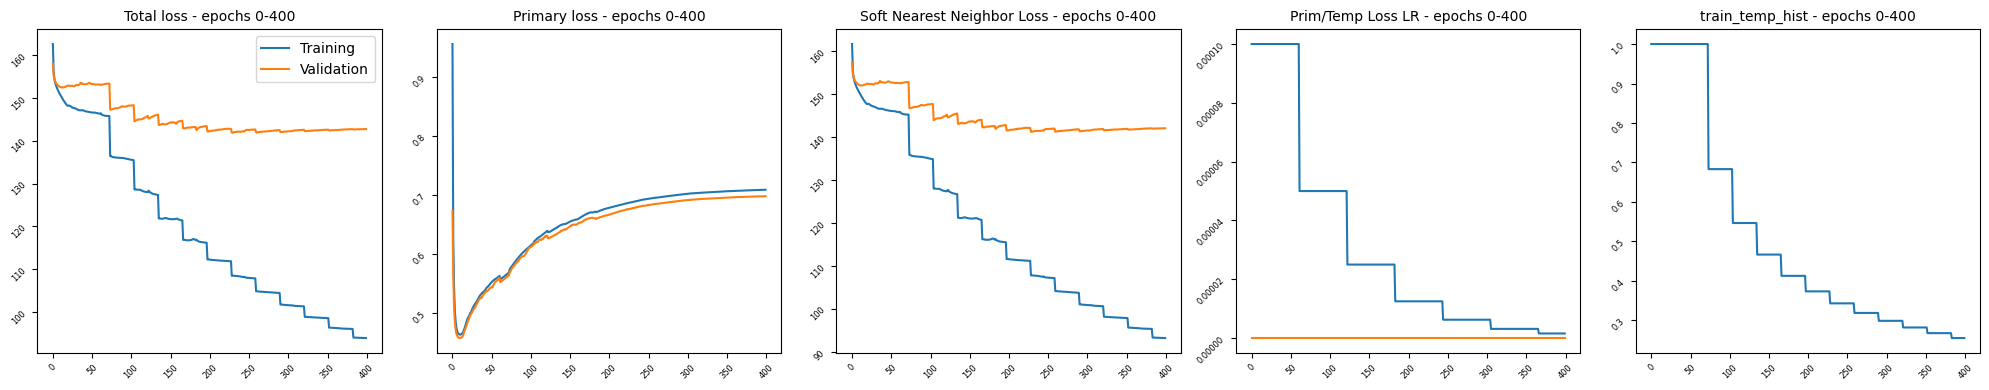

In [65]:
plot_train_history(model, start= 0, n_bins = 25)

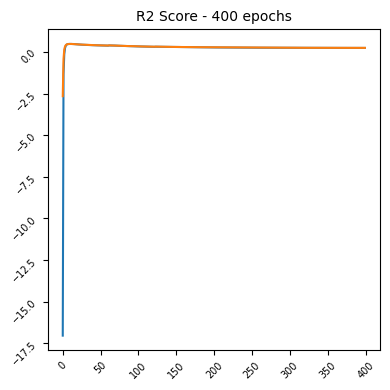

In [66]:
plot_regression_metrics(model,  n_bins = 25)

In [ ]:
# plot_train_history(model, start= 0, n_bins = 25)

In [ ]:
# plot_train_history(model, start= 0, n_bins = 25)

In [71]:
# plot_train_history(model, start= 100, n_bins = 25)